# Analyzing Neighborhoods in Chennai, India for Starting a Restaurant

## Introduction

Chennai has wide variety of food to offer, where the Idly Sambhar is a popular dish, which is served as breakfast or dinner. Apart from regular South Indian street food, the city's streets are also filled with several North Indian street food outlets, most of them established by North Indian migrants themselves. It has many restuarents which offer Idli Sambar, Dosa, Uttapam, Paniyaram, Jigarthanda and many more. Using data science concepts I want to find which area is the best to open a new restaurent.

## Data Collection

The data required for this project has been collected from multiple sources. A summary of the data required for this project is given below.

### Neighborhoods Data
The data of the neighborhoods in Chennai was scraped from https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Chennai. The data is read into a pandas data frame using the read_html() method. The main reason for doing so is that the Wikipedia page provides a comprehensive and detailed table of the data which can easily be scraped using the read_html() method of pandas.

### Geographical Coordinates
The geographical coordinates for Chennai data has been obtained from the GeoPy library in python. This data is relevant for plotting the map of Chennai using the Folium library in python. The geocoder library in python has been used to obtain latitude and longitude data for various neighborhoods in Chennai. The coordinates of all neighborhoods in Chennai are used to check the accuracy of coordinates given on Wikipedia and replace them in our data frame if the absolute difference is more than 0.001. These coordinates are then further used for plotting using the Folium library in python.

### Venue Data
The venue data has been extracted using the Foursquare API. This data contains venue recommendations for all neighborhoods in Chennai and is used to study the popular venues of different neighborhoods.

### Importing required libraries

In [39]:
!pip3 install geopy
!pip3 install geocoder
!pip3 install folium
!pip3 install lxml

import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score
from bs4 import BeautifulSoup

%matplotlib inline

print('All libraries imported.')

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
All libraries imported.


### Data Retrieval

Scraping data from https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Chennai and reading it into a dataframe.

In [22]:
main_url = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Chennai"

df = pd.read_html(main_url)[-2]
df.rename(columns={'Area': 'Neighborhood'}, inplace=True)
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Adambakkam,South and East Chennai,12.9880,80.2047
1,Adyar,South and East Chennai,13.0012,80.2565
2,Alandur,South and East Chennai,12.9975,80.2006
3,Alapakkam,West Chennai,13.0490,80.1673
4,Alwarthirunagar,West Chennai,13.0426,80.1840
5,Ambattur,West Chennai,13.1143,80.1548
6,Aminjikarai,West Chennai,13.0698,80.2245
7,Anna Nagar,West Chennai,13.0850,80.2101
8,Annanur,West Chennai,13.1184,80.1246
9,Arumbakkam,West Chennai,13.0724,80.2102


### Data Wrangling

Lets look at the different values for Location present in the Location column.

In [23]:
df['Location'].value_counts()

North Chennai                           57
South and East Chennai                  48
West Chennai                            45
Northern Suburbs of Chennai              7
Western Suburbs of Chennai               6
Suburbs along ECR and OMR of Chennai     6
Southern-Eastern Suburbs of Chennai      5
Suburban Chennai                         2
Name: Location, dtype: int64

We can see that there are many locations that appear only once or twice. This is because the main locations like "Western Suburbs" or "South Chennai" are being further divided by the area within these locations. Lets clean the Location column to make it easier to understand.

In [24]:
df['Location'] = df['Location'].apply(lambda x: x.split(',')[-1])
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Adambakkam,South and East Chennai,12.9880,80.2047
1,Adyar,South and East Chennai,13.0012,80.2565
2,Alandur,South and East Chennai,12.9975,80.2006
3,Alapakkam,West Chennai,13.0490,80.1673
4,Alwarthirunagar,West Chennai,13.0426,80.1840
5,Ambattur,West Chennai,13.1143,80.1548
6,Aminjikarai,West Chennai,13.0698,80.2245
7,Anna Nagar,West Chennai,13.0850,80.2101
8,Annanur,West Chennai,13.1184,80.1246
9,Arumbakkam,West Chennai,13.0724,80.2102


Now lets again look at the values in Location column.

In [25]:
df['Location'].value_counts()

North Chennai                           57
South and East Chennai                  48
West Chennai                            45
Northern Suburbs of Chennai              7
Western Suburbs of Chennai               6
Suburbs along ECR and OMR of Chennai     6
Southern-Eastern Suburbs of Chennai      5
Suburban Chennai                         2
Name: Location, dtype: int64

Now that the data is much easier to interpret, lets display the dataframe created.

Although the data we gathered contained latitude and longitude information, we can reconfirm these coordinates using Geocoder.

In [29]:
df['Latitude1'] = None
df['Longitude1'] = None

for i, neigh in enumerate(df['Neighborhood']):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Chennai, India'.format(neigh))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    df.loc[i, 'Latitude1'] = latitude
    df.loc[i, 'Longitude1'] = longitude

df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Adambakkam,South and East Chennai,12.99192,80.20603,12.99192,80.20603,0.00392,0.00133
1,Adyar,South and East Chennai,13.00304,80.25187,13.00304,80.25187,0.00184,0.00463
2,Alandur,South and East Chennai,13.00013,80.2006,13.00013,80.20049,0.00263,0.00011
3,Alapakkam,West Chennai,13.04613,80.16501,13.04613,80.16501,0.00287,0.00229
4,Alwarthirunagar,West Chennai,13.05055,80.184,13.05055,80.18397,0.00795,0.00003
5,Ambattur,West Chennai,13.11882,80.1548,13.11882,80.15442,0.00452,0.00038
6,Aminjikarai,West Chennai,13.07139,80.22256,13.07139,80.22256,0.00159,0.00194
7,Anna Nagar,West Chennai,13.08359,80.2101,13.08359,80.21015,0.00141,0.00005
8,Annanur,West Chennai,13.11212,80.12895,13.11212,80.12895,0.00628,0.00435
9,Arumbakkam,West Chennai,13.0724,80.2102,13.07308,80.20952,0.00068,0.00068


We can create new columns to see the difference between coordinate values obtained from wikipedia and those obtained from geocoder. We will take the absolute difference between these values and store them in our dataframe.

In [30]:
df['Latdiff'] = abs(df['Latitude'] - df['Latitude1'])
df['Longdiff'] = abs(df['Longitude'] - df['Longitude1'])
df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Adambakkam,South and East Chennai,12.99192,80.20603,12.99192,80.20603,0.0,0.0
1,Adyar,South and East Chennai,13.00304,80.25187,13.00304,80.25187,0.0,0.0
2,Alandur,South and East Chennai,13.00013,80.2006,13.00013,80.20049,0.0,0.00011
3,Alapakkam,West Chennai,13.04613,80.16501,13.04613,80.16501,0.0,0.0
4,Alwarthirunagar,West Chennai,13.05055,80.184,13.05055,80.18397,0.0,0.00003
5,Ambattur,West Chennai,13.11882,80.1548,13.11882,80.15442,0.0,0.00038
6,Aminjikarai,West Chennai,13.07139,80.22256,13.07139,80.22256,0.0,0.0
7,Anna Nagar,West Chennai,13.08359,80.2101,13.08359,80.21015,0.0,0.00005
8,Annanur,West Chennai,13.11212,80.12895,13.11212,80.12895,0.0,0.0
9,Arumbakkam,West Chennai,13.0724,80.2102,13.07308,80.20952,0.00068,0.00068


We can see that the latitude and longitudes from wikipedia and geocoder are very similar, yet there are some differences. We will replace the values with the coordinates obtained from geocoder if the absolute difference is more than 0.001.

In [31]:
df.loc[df.Latdiff>0.001, 'Latitude'] = df.loc[df.Latdiff>0.001, 'Latitude1']
df.loc[df.Longdiff>0.001, 'Longitude'] = df.loc[df.Longdiff>0.001, 'Longitude1']
df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Adambakkam,South and East Chennai,12.99192,80.20603,12.99192,80.20603,0.0,0.0
1,Adyar,South and East Chennai,13.00304,80.25187,13.00304,80.25187,0.0,0.0
2,Alandur,South and East Chennai,13.00013,80.2006,13.00013,80.20049,0.0,0.00011
3,Alapakkam,West Chennai,13.04613,80.16501,13.04613,80.16501,0.0,0.0
4,Alwarthirunagar,West Chennai,13.05055,80.184,13.05055,80.18397,0.0,0.00003
5,Ambattur,West Chennai,13.11882,80.1548,13.11882,80.15442,0.0,0.00038
6,Aminjikarai,West Chennai,13.07139,80.22256,13.07139,80.22256,0.0,0.0
7,Anna Nagar,West Chennai,13.08359,80.2101,13.08359,80.21015,0.0,0.00005
8,Annanur,West Chennai,13.11212,80.12895,13.11212,80.12895,0.0,0.0
9,Arumbakkam,West Chennai,13.0724,80.2102,13.07308,80.20952,0.00068,0.00068


In order to confirm if values have actually been replaced we can use the where method. Values with NaN means those values have not been replaced.

In [32]:
df.where(df['Latitude']==df['Latitude1'])

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Adambakkam,South and East Chennai,12.99192,80.20603,12.99192,80.20603,0.0,0.0
1,Adyar,South and East Chennai,13.00304,80.25187,13.00304,80.25187,0.0,0.0
2,Alandur,South and East Chennai,13.00013,80.2006,13.00013,80.20049,0.0,0.00011
3,Alapakkam,West Chennai,13.04613,80.16501,13.04613,80.16501,0.0,0.0
4,Alwarthirunagar,West Chennai,13.05055,80.184,13.05055,80.18397,0.0,0.00003
...,...,...,...,...,...,...,...,...
171,Kanathur,Suburbs along ECR and OMR of Chennai,12.84718,80.24137,12.84718,80.24137,0.0,0.0
172,Muthukadu,Suburbs along ECR and OMR of Chennai,12.83165,80.24207,12.83165,80.24207,0.0,0.0
173,Kelambakkam,Suburbs along ECR and OMR of Chennai,12.78614,80.2203,12.78614,80.2203,0.0,0.0
174,Kovalam,Suburbs along ECR and OMR of Chennai,12.78986,80.2504,12.78986,80.24951,0.0,0.00089


We can do the same for the Longitude column.

In [33]:
df.where(df['Longitude']==df['Longitude1'])

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Adambakkam,South and East Chennai,12.99192,80.20603,12.99192,80.20603,0.0,0.0
1,Adyar,South and East Chennai,13.00304,80.25187,13.00304,80.25187,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alapakkam,West Chennai,13.04613,80.16501,13.04613,80.16501,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
171,Kanathur,Suburbs along ECR and OMR of Chennai,12.84718,80.24137,12.84718,80.24137,0.0,0.0
172,Muthukadu,Suburbs along ECR and OMR of Chennai,12.83165,80.24207,12.83165,80.24207,0.0,0.0
173,Kelambakkam,Suburbs along ECR and OMR of Chennai,12.78614,80.2203,12.78614,80.2203,0.0,0.0
174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now that we have the data, we can drop the columns that are no longer useful.

In [34]:
df.drop(['Latitude1', 'Longitude1', 'Latdiff', 'Longdiff'], axis=1, inplace=True)
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Adambakkam,South and East Chennai,12.99192,80.20603
1,Adyar,South and East Chennai,13.00304,80.25187
2,Alandur,South and East Chennai,13.00013,80.2006
3,Alapakkam,West Chennai,13.04613,80.16501
4,Alwarthirunagar,West Chennai,13.05055,80.184
5,Ambattur,West Chennai,13.11882,80.1548
6,Aminjikarai,West Chennai,13.07139,80.22256
7,Anna Nagar,West Chennai,13.08359,80.2101
8,Annanur,West Chennai,13.11212,80.12895
9,Arumbakkam,West Chennai,13.0724,80.2102


### Data Visualization

To understand our data better, we can see how many neighborhoods are in each location.

In [37]:
neighborhoods_Chennai = df.groupby('Location')['Neighborhood'].nunique()
neighborhoods_Chennai

Location
North Chennai                           57
Northern Suburbs of Chennai              7
South and East Chennai                  48
Southern-Eastern Suburbs of Chennai      5
Suburban Chennai                         2
Suburbs along ECR and OMR of Chennai     6
West Chennai                            45
Western Suburbs of Chennai               6
Name: Neighborhood, dtype: int64

We can now plot this data.

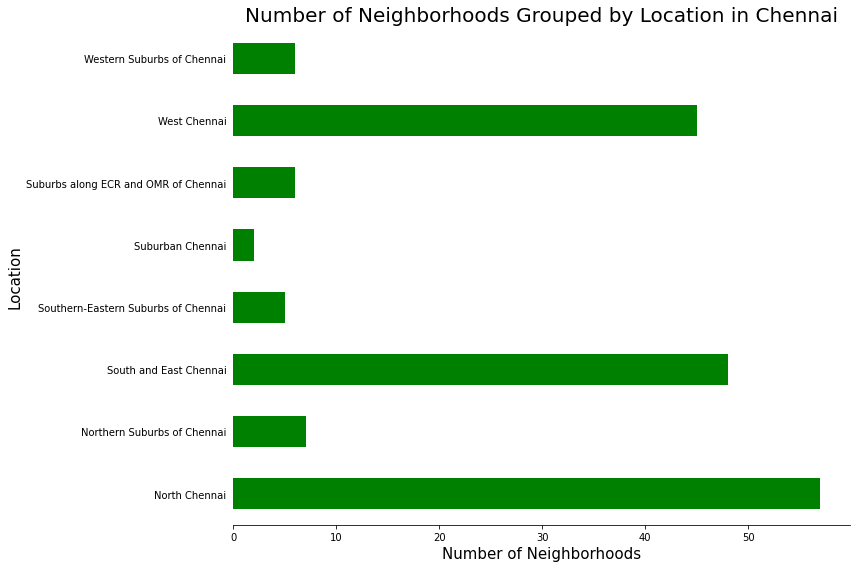

In [41]:
fig = plt.figure(figsize=(12,8))

ax = neighborhoods_Chennai.plot(kind='barh', color='green')
ax.set_title('Number of Neighborhoods Grouped by Location in Chennai', fontsize=20)
ax.set_xlabel('Number of Neighborhoods', fontsize=15)
ax.set_ylabel('Location', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(which='major', left=False)

fig.tight_layout()

Clearly we can see that South Chennai and Western Suburbs have the most number of neighborhoods. Notice how we see one of the locations as Chennai itself? This is because the neighborhoods contained in this location are located at the outskirts of Chennai and thus have been grouped as just Chennai.

Now lets visualize the neighborhoods on a map using Folium. First we will obtain the geographical coordinates of Chennai using GeoPy.

In [44]:
address = 'Chennai, IN'
geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Chennai are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Chennai are 13.0836939, 80.270186.


Now we can plot the map.

In [45]:
map_mum = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(df['Latitude'], df['Longitude'], df['Location'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mum)  
    
map_mum

### Using Foursquare API

Now we can start working with the Foursquare API to obtain venue recommendations.

Lets create the Foursquare credentials first.

In [50]:
CLIENT_ID='GAP4OI301LO2WXCU5W4WFVFQ5MWJVDIXI0NL55ZH3USG3SFK'
CLIENT_SECRET='5EPSD0GTW3YKN3JIDG5LMJJ4PL1UURWNDEB4F4LTF3RVYBWM'
VERSION='20180605'

Lets start by exploring just the first neighborhood in our dataframe using Foursquare API.

In [48]:
neighborhood_name = df.loc[0, 'Neighborhood']
neighborhood_lat = df.loc[0, 'Latitude']
neighborhood_long = df.loc[0, 'Longitude']

print("The neighborhood is {} and it's geographical coordinates are {} latitude and {} longitude".format(neighborhood_name,
                                                                                                        neighborhood_lat, neighborhood_long))

The neighborhood is Adambakkam and it's geographical coordinates are 12.99192000000005 latitude and 80.20603000000006 longitude


We will now extract the top 200 venues near Amboli with a radius of 1000m or 1km. In order to do this, we will start by creating a url.

In [51]:
LIMIT = 200
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_long, 
    radius, 
    LIMIT)

We can now use the GET method to get our results.

In [52]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60ce10a8edff614526e3d2d4'},
 'response': {'headerLocation': 'Velachery',
  'headerFullLocation': 'Velachery, Chennai',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 8,
  'suggestedBounds': {'ne': {'lat': 13.000920009000058,
    'lng': 80.21524920008119},
   'sw': {'lat': 12.982919991000042, 'lng': 80.19681079991892}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5155ca10e4b0cc3dad2cf381',
       'name': 'Pizza Republic',
       'location': {'address': 'VIHAS Restaurant',
        'crossStreet': '195/5 Medavakkam Main Road, Adambakkam',
        'lat': 12.99098677891081,
        'lng': 80.19861315843515,
        'labeledLatLngs': [{'label': 'display',
          'lat': 12.99098677891081,
          'lng': 80.198613158

We will now create a function get_category_type to extract the categories of venues.

In [53]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we can clean the JSON obtained using the GET method and store our results in a dataframe.

In [54]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-54-dc733077f29a>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues)


,name,categories,lat,lng
0,Pizza Republic,Pizza Place,12.990987,80.198613
1,Loiee,Bakery,12.992197,80.199000
2,Venkateshwara Super Market,Department Store,12.986320,80.205168
3,St Thomas Mount Railway Station,Train Station,12.994987,80.200302
4,Deepam Restaurant,Indian Restaurant,12.985380,80.205281


We can check how many venues were returned by Foursquare.

In [55]:
print("{} venues were returned for {} by Foursquare".format(len(nearby_venues), neighborhood_name))

8 venues were returned for Adambakkam by Foursquare


### Generalizing Foursquare API

Now that we have seen how the API call works and how we can clean our data to get relevant information, we can generalize this procedure to get nearby venues for all neighborhoods by creating the function getNearbyVenues.

In [56]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We can apply the function created to get nearby venues for all neighborhoods in Chennai. We will get 200 nearby venues within a 1km radius, same as before.

In [57]:
mum_venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=radius)

Adambakkam
Adyar
Alandur
Alapakkam
Alwarthirunagar
Ambattur
Aminjikarai
Anna Nagar
Annanur
Arumbakkam
Ashok Nagar
Avadi
Ayappakkam
Basin Bridge
Besant Nagar
Broadway
Central
Chetpet
Choolai
MMDA Colony
Defence Colony
Egmore
Ennore
Erukanchery
George Town
Gerugambakkam
Gopalapuram
Guindy
Hastinapuram
ICF Colony
Injambakkam
Irumbuliyur
Iyyapanthangal
Jamalia
K.K. Nagar
Kadaperi
Kallikuppam
Karambakkam
Kathirvedu
Kathivakkam
Keelkattalai
Kodungaiyur
Kolappakkam
Kolathur
Korattur
Korukkupet
Kosapet
Kottivakkam
Kovilambakkam
Koyambedu
Kundrathur
Lakshmipuram
M.G.R. Garden
M.G.R. Nagar
M.K.B. Nagar
Madhavaram
Madhavaram Milk Colony
Madipakkam
Maduravoyal
Mambakkam
Manali
Manali New Town
manapakkam
Mangadu
Manjambakkam
Mannadi
Mathur MMDA
Medavakkam
Minjur
Mogappair
Moolakadai
Mowlivakkam
Mudichur
Mugalivakkam
Mylapore
Nagalkeni
Nandambakkam
Nanganallur
Naravarikuppam
Neelankarai
Nerkundrum
Nesapakkam
New Washermenpet
Nolambur
Old Washermenpet
Oragadam
Otteri
Padi
Palavakkam
Pallavaram
Pallik

Lets see what our dataframe looks like.

In [58]:
print(mum_venues.shape)
mum_venues.head(10)

(1818, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,12.99192,80.20603,Pizza Republic,12.990987,80.198613,Pizza Place
1,Adambakkam,12.99192,80.20603,Loiee,12.992197,80.199000,Bakery
2,Adambakkam,12.99192,80.20603,Venkateshwara Super Market,12.986320,80.205168,Department Store
3,Adambakkam,12.99192,80.20603,St Thomas Mount Railway Station,12.994987,80.200302,Train Station
4,Adambakkam,12.99192,80.20603,Deepam Restaurant,12.985380,80.205281,Indian Restaurant
5,Adambakkam,12.99192,80.20603,Design Hotel Chennai by jüSTa,12.992068,80.214965,Hotel
6,Adambakkam,12.99192,80.20603,St. Thomas Mount Metro Station,12.994772,80.197556,Metro Station
7,Adambakkam,12.99192,80.20603,Heritage Fresh,13.000499,80.208087,Supermarket
8,Adyar,13.00304,80.25187,ibaco,13.005864,80.251764,Ice Cream Shop
9,Adyar,13.00304,80.25187,Domino's Pizza,13.002000,80.254000,Pizza Place


Lets see how many venues were returned for each neighborhood.

In [59]:
mum_venues.groupby('Neighborhood', as_index=False).count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,8,8,8,8,8,8
1,Adyar,61,61,61,61,61,61
2,Alandur,13,13,13,13,13,13
3,Alapakkam,7,7,7,7,7,7
4,Alwarthirunagar,13,13,13,13,13,13
...,...,...,...,...,...,...,...
156,Villivakkam,4,4,4,4,4,4
157,Virugambakkam,4,4,4,4,4,4
158,Vyasarpadi,3,3,3,3,3,3
159,West Mambalam,16,16,16,16,16,16


We can now check how many unique categories are there in our data.

In [60]:
print("There are {} unique categories".format(mum_venues['Venue Category'].nunique()))

There are 189 unique categories


### Analyzing each neighborhood

We can start analyzing each neighborhood by One-hot Encoding to see which categories belong in which neighborhoods.

In [61]:
mum_onehot = pd.get_dummies(mum_venues[['Venue Category']], prefix="", prefix_sep="")
mum_onehot.head()

,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Antique Shop,Arcade,...,Trail,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Adding Neighborhood column to the one-hot encoded dataframe.

In [66]:
mum_onehot['Neighborhood'] = mum_venues['Neighborhood']
mum_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Antique Shop,...,Trail,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Women's Store
0,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Moving the Neighborhood column to the first column.

In [67]:
temp = list(mum_onehot.columns)

if 'Neighborhood' in temp:
    temp.remove('Neighborhood')
    
fixed_columns = ['Neighborhood'] + temp
mum_onehot = mum_onehot[fixed_columns]

mum_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Antique Shop,...,Trail,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Women's Store
0,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can groupby neighborhood and take the mean for all categories.

In [68]:
mum_grouped = mum_onehot.groupby('Neighborhood', sort=False).mean().reset_index()
print(mum_grouped.shape)
mum_grouped.head(10)

(161, 190)


,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Antique Shop,...,Trail,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Women's Store
0,Adambakkam,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.125000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,Adyar,0.0,0.0,0.0,0.0,0.0,0.016393,0.0,0.0,0.0,...,0.0,0.0,0.016393,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,Alandur,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.076923,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,Alapakkam,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,Alwarthirunagar,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5,Ambattur,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
6,Aminjikarai,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
7,Anna Nagar,0.0,0.0,0.0,0.0,0.0,0.017241,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.051724,0.0,0.0,0.0,0.0,0.0
8,Annanur,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9,Arumbakkam,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0,0.0


In order to further understand the data, we can display the top 5 venues of all neighborhoods.

In [69]:
num_top_venues = 5

for hood in mum_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = mum_grouped[mum_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adambakkam----
               venue  freq
0              Hotel  0.12
1        Pizza Place  0.12
2      Metro Station  0.12
3        Supermarket  0.12
4  Indian Restaurant  0.12


----Adyar----
               venue  freq
0  Indian Restaurant  0.26
1        Pizza Place  0.07
2               Café  0.07
3     Clothing Store  0.05
4         Food Court  0.03


----Alandur----
           venue  freq
0         Bakery  0.15
1      Hotel Bar  0.15
2  Metro Station  0.15
3           Café  0.08
4    Pizza Place  0.08


----Alapakkam----
                  venue  freq
0        Clothing Store  0.14
1      Department Store  0.14
2  Fast Food Restaurant  0.14
3        Sandwich Place  0.14
4      Asian Restaurant  0.14


----Alwarthirunagar----
                  venue  freq
0  Fast Food Restaurant  0.15
1     Indian Restaurant  0.15
2        Clothing Store  0.15
3            Smoke Shop  0.08
4                   Gym  0.08


----Ambattur----
              venue  freq
0     Movie Theater   0.2
1       

Lets now create a dataframe with the top 10 common venues for each neighborhood.

In [70]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [122]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mum_grouped['Neighborhood']

for ind in np.arange(mum_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mum_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,Hotel,Pizza Place,Metro Station,Supermarket,Indian Restaurant,Train Station,Department Store,Bakery,Nightclub,New American Restaurant
1,Adyar,Indian Restaurant,Pizza Place,Café,Clothing Store,Food Court,North Indian Restaurant,Chinese Restaurant,Electronics Store,Dessert Shop,Asian Restaurant
2,Alandur,Bakery,Hotel Bar,Metro Station,Café,Pizza Place,Church,Train Station,Hotel,Italian Restaurant,Breakfast Spot
3,Alapakkam,Clothing Store,Department Store,Fast Food Restaurant,Sandwich Place,Asian Restaurant,Chettinad Restaurant,Bakery,Persian Restaurant,Nightclub,North Indian Restaurant
4,Alwarthirunagar,Fast Food Restaurant,Indian Restaurant,Clothing Store,Smoke Shop,Gym,Pizza Place,Movie Theater,Ice Cream Shop,Café,Chettinad Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
156,Kanathur,Café,Juice Bar,Multiplex,Pool Hall,Portuguese Restaurant,Museum,Music Store,Music Venue,New American Restaurant,Nightclub
157,Muthukadu,Indian Restaurant,Hotel,Museum,Coffee Shop,Theme Park,Park,Music Store,Music Venue,New American Restaurant,Nightclub
158,Kelambakkam,Café,Bus Station,Indian Restaurant,Optical Shop,Coffee Shop,ATM,Park,Music Venue,New American Restaurant,Nightclub
159,Kovalam,Hotel,Seafood Restaurant,Café,Resort,Restaurant,Indian Restaurant,Surf Spot,Beach,Bar,Music Venue


### Clustering neighborhoods

Now we can use KMeans clustering method to cluster the neighborhoods.

First we need to determine how many clusters to use. This will be done using the Silhouette Score.

We will define a function to plot the Silhouette Score that will be calculated using different number of clusters. 

In [72]:
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [73]:
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = mum_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(cl_df) #Choose any random_state
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

We can now display the scores for different number of clusters and plot the data as well.

[0.08138831072223696, 0.09550694238995203, 0.10959737236999617, 0.12483849491991174, 0.08697864894864671, 0.09032457093453937, 0.12163016412008383, 0.07593603277110988, 0.11048555320464463, 0.1179092741194736, 0.15544592123307238, 0.11216366062296812, 0.10900818995089975, 0.14302837572444524]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


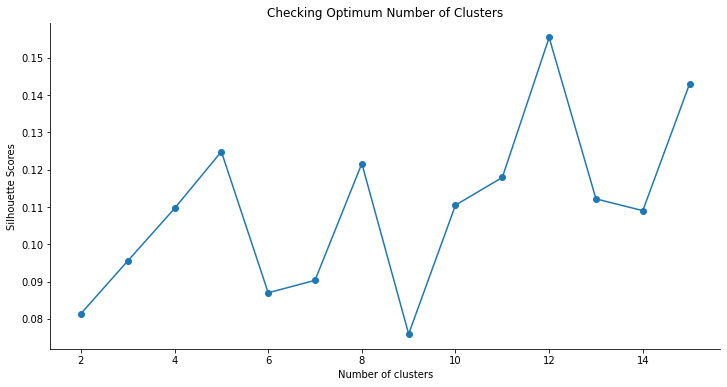

In [74]:
print(scores)
print(kval)
plot(kval, scores)

We can see that the silhouette scores are not very high even as we increase the number of clusters. This means that the inter-cluster distance between different clusters is not very high over the range of k-values. However, we will try to cluster our data as best as we can. For this, we will use 5 clusters for our clustering model since it provides the highest silhouette score as seen above.

In [97]:
k = 5

mum_clustering = mum_grouped.drop('Neighborhood', axis=1)
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit(mum_clustering) #Can choose any random_state

kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 4, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 4, 2, 2, 0, 2, 3, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 0, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 1, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 0, 0, 2, 3, 2, 0, 2, 2, 2, 2, 2,
       2, 0, 2, 0, 2, 2, 2], dtype=int32)

Now we can create a new dataframe that includes cluster labels and the top 10 venues.

In [126]:
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
mum_merged = df
mum_merged = mum_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Lets view the newly created dataframe.

In [133]:
mum_merged.dropna(inplace=True)
print(mum_merged.shape)

(167, 15)


We can visualize the clustering by creating a map.

In [135]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(mum_merged['Latitude'], mum_merged['Longitude'], mum_merged['Neighborhood'], mum_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can now view the neighborhoods in each cluster and their top 10 most common venues.

### Cluster 1

In [136]:
mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Kadaperi,South and East Chennai,Indian Restaurant,Jewelry Store,Platform,Light Rail Station,Train Station,Mobile Phone Shop,Paper / Office Supplies Store,Museum,Music Store,Music Venue
46,Kosapet,North Chennai,Indian Restaurant,Department Store,Hotel,Diner,Pool Hall,Park,Music Store,Music Venue,New American Restaurant,Nightclub
51,Lakshmipuram,North Chennai,Indian Restaurant,Department Store,Electronics Store,Intersection,Hotel,ATM,Park,Music Store,Music Venue,New American Restaurant
57,Madipakkam,South and East Chennai,Indian Restaurant,Department Store,Grocery Store,Park,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant
64,Manjambakkam,North Chennai,Indian Restaurant,ATM,Paper / Office Supplies Store,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant
67,Medavakkam,South and East Chennai,Indian Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Convenience Store,Pizza Place,ATM,Music Store,Music Venue,New American Restaurant,Nightclub
90,Pallikaranai,South and East Chennai,Indian Restaurant,ATM,Paper / Office Supplies Store,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant
150,Kancheepuram,Suburban Chennai,Sports Club,Indian Restaurant,ATM,Paper / Office Supplies Store,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub
151,Chengalpattu,Suburban Chennai,Sports Club,Indian Restaurant,ATM,Paper / Office Supplies Store,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub
159,Tiruvallur,Western Suburbs of Chennai,Indian Restaurant,Metro Station,ATM,Paper / Office Supplies Store,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant


### Cluster 2

In [137]:
mum_merged.loc[mum_merged['Cluster Labels'] == 1, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Annanur,West Chennai,Platform,Train Station,Stationery Store,Medical Supply Store,ATM,Paper / Office Supplies Store,Museum,Music Store,Music Venue,New American Restaurant
11,Avadi,West Chennai,Park,Department Store,Breakfast Spot,IT Services,ATM,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant
13,Basin Bridge,North Chennai,Platform,Light Rail Station,Pizza Place,Train Station,Thrift / Vintage Store,ATM,Paper / Office Supplies Store,Museum,Music Store,Music Venue
38,Kathirvedu,North Chennai,Department Store,Food & Drink Shop,Park,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant,Office,Optical Shop
80,Nerkundrum,West Chennai,Department Store,Playground,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Paper / Office Supplies Store,Museum,Music Store,Music Venue,New American Restaurant,Nightclub
84,Old Washermenpet,North Chennai,Women's Store,Train Station,Bus Station,Department Store,Vietnamese Restaurant,Multicuisine Indian Restaurant,Museum,Music Store,Music Venue,New American Restaurant
86,Otteri,North Chennai,Department Store,Bus Station,Bike Rental / Bike Share,Bakery,BBQ Joint,ATM,Park,Music Venue,New American Restaurant,Nightclub
89,Pallavaram,South and East Chennai,Hotel,Department Store,Airport Terminal,Bus Station,Pizza Place,Train Station,Hyderabadi Restaurant,ATM,Music Store,Music Venue
94,Pattabiram,North Chennai,ATM,Platform,Light Rail Station,Supermarket,Concert Hall,Paper / Office Supplies Store,Museum,Music Store,Music Venue,New American Restaurant
99,Perambur,North Chennai,Department Store,Pizza Place,Snack Place,Multiplex,Pool,Playground,Museum,Music Store,Music Venue,New American Restaurant


### Cluster 3

In [138]:
mum_merged.loc[mum_merged['Cluster Labels'] == 2, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,South and East Chennai,Hotel,Pizza Place,Metro Station,Supermarket,Indian Restaurant,Train Station,Department Store,Bakery,Nightclub,New American Restaurant
1,Adyar,South and East Chennai,Indian Restaurant,Pizza Place,Café,Clothing Store,Food Court,North Indian Restaurant,Chinese Restaurant,Electronics Store,Dessert Shop,Asian Restaurant
2,Alandur,South and East Chennai,Bakery,Hotel Bar,Metro Station,Café,Pizza Place,Church,Train Station,Hotel,Italian Restaurant,Breakfast Spot
3,Alapakkam,West Chennai,Clothing Store,Department Store,Fast Food Restaurant,Sandwich Place,Asian Restaurant,Chettinad Restaurant,Bakery,Persian Restaurant,Nightclub,North Indian Restaurant
4,Alwarthirunagar,West Chennai,Fast Food Restaurant,Indian Restaurant,Clothing Store,Smoke Shop,Gym,Pizza Place,Movie Theater,Ice Cream Shop,Café,Chettinad Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
169,Guduvanchery,Southern-Eastern Suburbs of Chennai,Clothing Store,Indie Movie Theater,North Indian Restaurant,Train Station,Indian Restaurant,Bakery,Park,Music Store,Music Venue,New American Restaurant
171,Kanathur,Suburbs along ECR and OMR of Chennai,Café,Juice Bar,Multiplex,Pool Hall,Portuguese Restaurant,Museum,Music Store,Music Venue,New American Restaurant,Nightclub
173,Kelambakkam,Suburbs along ECR and OMR of Chennai,Café,Bus Station,Indian Restaurant,Optical Shop,Coffee Shop,ATM,Park,Music Venue,New American Restaurant,Nightclub
174,Kovalam,Suburbs along ECR and OMR of Chennai,Hotel,Seafood Restaurant,Café,Resort,Restaurant,Indian Restaurant,Surf Spot,Beach,Bar,Music Venue


### Cluster 4

In [139]:
mum_merged.loc[mum_merged['Cluster Labels'] == 3, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Ennore,North Chennai,Train Station,ATM,Paper / Office Supplies Store,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant
66,Mathur MMDA,North Chennai,Pharmacy,ATM,Park,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant,Office
131,Thirunindravur,West Chennai,Train Station,Pharmacy,ATM,Paper / Office Supplies Store,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub
133,Thiruverkadu,West Chennai,Pharmacy,ATM,Park,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant,Office
154,Athipattu,Northern Suburbs of Chennai,Train Station,Platform,ATM,Paper / Office Supplies Store,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub
158,Ennore,Northern Suburbs of Chennai,Train Station,ATM,Paper / Office Supplies Store,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant
161,Thirunindravur,Western Suburbs of Chennai,Train Station,Pharmacy,ATM,Paper / Office Supplies Store,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub


### Cluster 5

In [140]:
mum_merged.loc[mum_merged['Cluster Labels'] == 4, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,MMDA Colony,West Chennai,Bike Rental / Bike Share,ATM,Multicuisine Indian Restaurant,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant,Office
61,Manali New Town,North Chennai,Bike Rental / Bike Share,ATM,Multicuisine Indian Restaurant,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant,Office


## Results and Discussion

By analyzing the five clusters obtained we can see that some of the clusters are more suited for restaurants and hotels, whereas, other clusters are less suited. Neighborhoods in clusters 3, 4, and 5 contain a small percentage of restaurants, hotels, cafe and pubs in their top 10 common venues. These clusters contain a higher degree of other venues like train station, bus station, fish market, gym, performing arts venue and smoke shop, to name a few. Thus, they are not well suited for opening a new restaurant. On the other hand, neighborhoods in clusters 1 and 2 contain a much higher degree of restaurants, hotels, multiplex, and other food joints. Thus, the neighborhoods in these clusters would be well suited for opening a new restaurant.

Comparing clusters 1 and 2, neighborhoods in cluster 1 seem to be more suited for starting a restaurant since they contains a larger percentage of food joints in the top 10 most common venues than cluster 2. Most neighborhoods in cluster 2 seem to have Indian Restaurant as their top most common venue; however, on careful analysis we can see that neighborhoods in cluster 2 also contain other venues like soccer field, flea market, smoke shop, gym, train station, dance studio, music store and so on. Thus, it is recommended that the new restaurant can be opened in the neighborhoods belonging to cluster 1. This neighborhood can be further plotted on a map as shown below.

In [143]:
new_restaurant_neighborhoods = mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0, 1, 2, 3] + list(range(5, mum_merged.shape[1]))]]
new_restaurant_neighborhoods.head()

,Neighborhood,Location,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Kadaperi,South and East Chennai,12.9336,80.12431,Indian Restaurant,Jewelry Store,Platform,Light Rail Station,Train Station,Mobile Phone Shop,Paper / Office Supplies Store,Museum,Music Store,Music Venue
46,Kosapet,North Chennai,13.09453,80.2551,Indian Restaurant,Department Store,Hotel,Diner,Pool Hall,Park,Music Store,Music Venue,New American Restaurant,Nightclub
51,Lakshmipuram,North Chennai,13.13026,80.20792,Indian Restaurant,Department Store,Electronics Store,Intersection,Hotel,ATM,Park,Music Store,Music Venue,New American Restaurant
57,Madipakkam,South and East Chennai,12.9647,80.2087,Indian Restaurant,Department Store,Grocery Store,Park,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant
64,Manjambakkam,North Chennai,13.16556,80.22942,Indian Restaurant,ATM,Paper / Office Supplies Store,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant


In [144]:
map_res_locations = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(new_restaurant_neighborhoods['Latitude'], new_restaurant_neighborhoods['Longitude'],
                                            new_restaurant_neighborhoods['Location'], new_restaurant_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    folium.Marker([lat, lng], popup='{} has geographical coordinates ({:.4f}, {:.4f})'.format(label, lat, lng),
                  icon=folium.Icon(color='lightred'), tooltip=label).add_to(map_res_locations)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_res_locations) 

map_res_locations

## Conclusion

We have successfully analyzed the neighborhoods in Chennai, India for determining which would be the best neighborhoods for opening a new restaurant. Based on our analysis, neighborhoods in cluster 1 are recommended as locations for the new restaurant. This has also been plotted in the map above. The stakeholders and investors can further tune this by considering various other factors like transport, legal requirements, and costs associated. These were out of the scope for this project and thus were not considered.